In [1]:
%matplotlib inline
%run '../bin/notebook_utils.py'
#%run 'bin/plot_utilization.py'
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Expand the notebook to the width of the browser
plt.style.use('ggplot')

In [2]:
! radical-stack


  python               : 3.6.10
  pythonpath           : 
  virtualenv           : conda-parsl

  radical.analytics    : 1.5.0
  radical.gtod         : 1.5.0
  radical.pilot        : 1.5.2
  radical.saga         : 1.5.2
  radical.utils        : 1.5.2



In [3]:
'''
suds = ['rp.session.ss.2N.0000',
        #'rp.session.ss.2N.0001',#Drop
        #'rp.session.ss.2N.0003',#Drop
        #'rp.session.ss.36N.0000',#Drop
        #'rp.session.ss.36N.0001',#Drop
        'rp.session.ss.36N.0003',
        'rp.session.ws.72N.0009',
        #'rp.session.ws.72N.0011'#Drop
       ]

'''

suds = ['rp.session.ws.2N.0004',
        'rp.session.ws.36N.0004',
        'rp.session.ws.72N.0009']


sdir = '../RP/sessions/WS/'
sids = [sdir+s for s in suds]

In [4]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False)})

In [5]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': int(ss[sid]['ncores']/24)})

In [6]:
info = []

for sid in suds:
   
    u  = ss[sid]['u']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttc'  : p.duration(event=[  {ru.EVENT: 'state'        , ru.STATE: rp.NEW                }, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           } ]),
      'ttq_p': p.duration(event=[  {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_u': u.duration(event=[  {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p.duration(event=[  {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE        },
                                   [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]]),
        
      'pilot_lifetime': p.duration(event=[{ru.EVENT: 'bootstrap_0_start', ru.STATE: None},
                                          {ru.EVENT: 'bootstrap_0_stop', ru.STATE: None}])})
    u.timestamps
    p.timestamps
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_p'] - ss[sid]['ttx_u']})
    info.append({'session':sid,
                  'resource' : ss[sid]['pres'],
                  'pilot_lm' : ss[sid]['lm'], 
                  'pilots'   : ss[sid]['npilot'],
                  'ps_active': ss[sid]['npact'],
                  'cores'    : ss[sid]['ncores'],
                  'gpus'     : ss[sid]['ngpus'], 
                  'nodes'    : ss[sid]['nnodes'], 
                  'tasks'    : ss[sid]['nunit'], 
                  'ts_done'  : ss[sid]['nunit']-ss[sid]['nufail'],  
                  'ts_failed': ss[sid]['nufail'],
                  'Pilot life time':ss[sid]['pilot_lifetime'],
                  'Pilot TTX':ss[sid]['ttx_p'],
                  'Unit TTX':ss[sid]['ttx_u'],
                  'RCT overheads':ss[sid]['ovh_rtc']})
df_info = pd.DataFrame(info) 
df_info

,session,resource,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,ts_done,ts_failed,Pilot life time,Pilot TTX,Unit TTX,RCT overheads
0,rp.session.ws.2N.0004,xsede.comet_ssh,SSH,1,1,48,0,2,48,48,0,388.0,335.335340,310.0,25.335340
1,rp.session.ws.36N.0004,xsede.comet_ssh,SSH,1,1,864,0,36,864,864,0,547.0,494.856478,444.0,50.856478
2,rp.session.ws.72N.0009,xsede.comet_ssh,SSH,1,1,1728,0,72,1728,1728,0,730.0,636.845561,592.0,44.845561


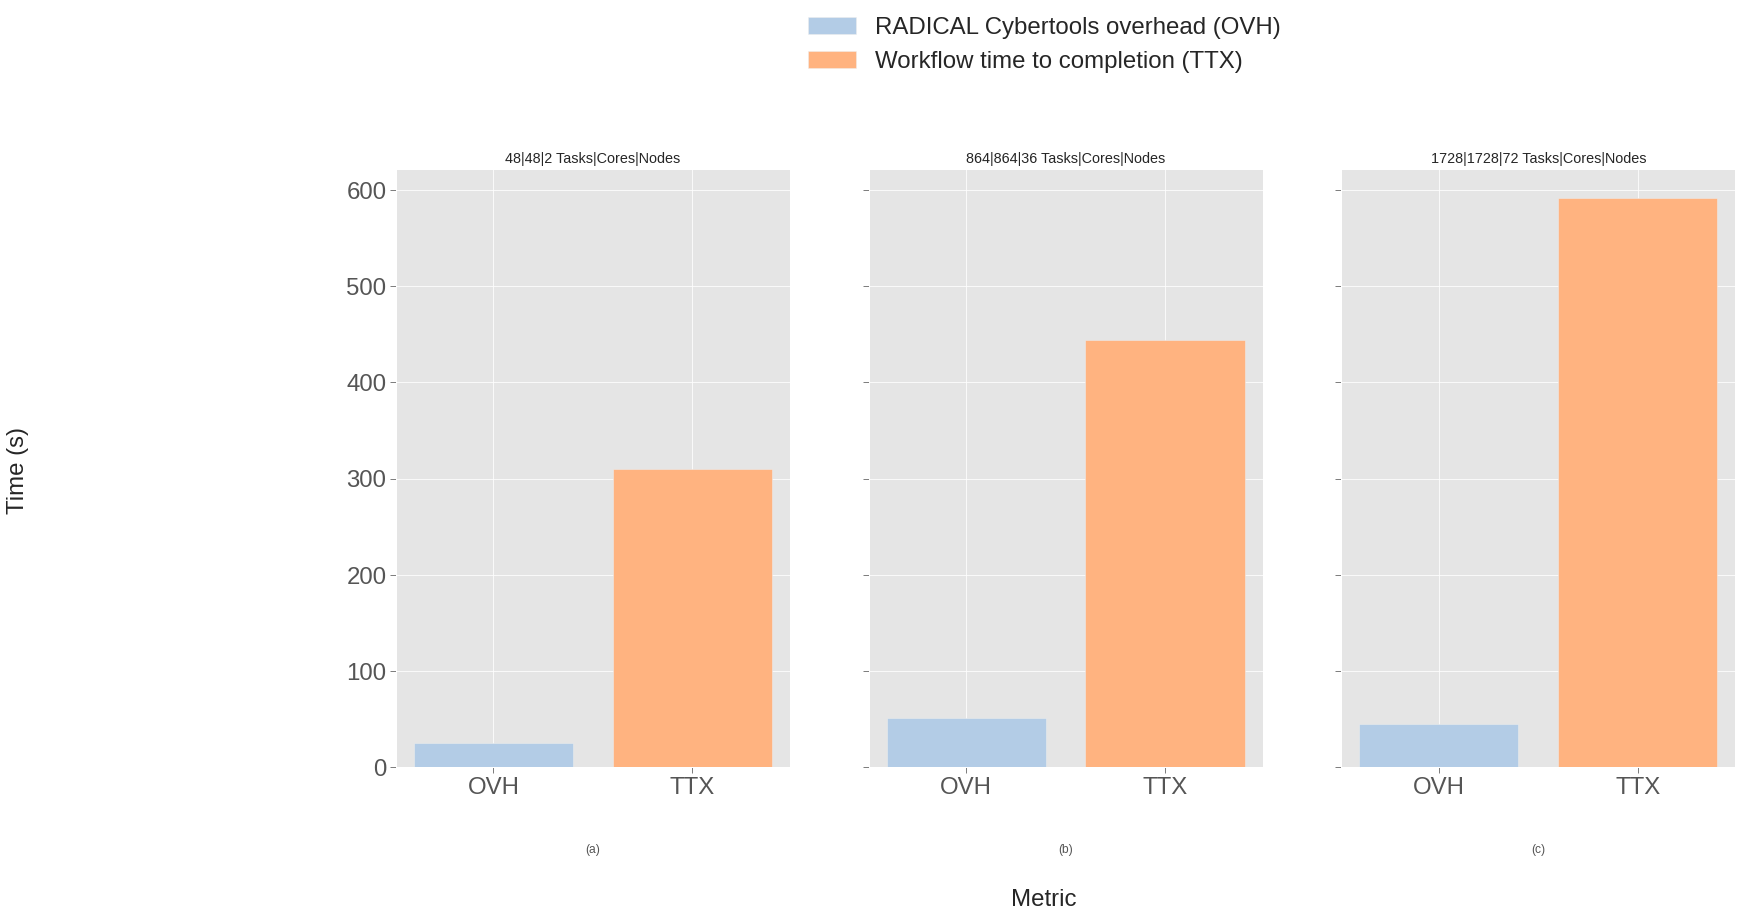

In [7]:
fwidth = 24
fhight = 11
fig, axarr = plt.subplots(1, len(suds), sharey=True, figsize=(fwidth, fhight))


i = 0
j = 'a'
for sid in suds:
    if len(suds) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s|%s|%s Tasks|Cores|Nodes' % (ss[sid]['nunit'],ss[sid]['ncores'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text(-0.1,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text( 0.5, -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.5, 1.1), fontsize=24, ncol=1)
plt.savefig('../figures/ws_rp_ttx_ovh.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('figures/incite2020_ovh_ttx.png', dpi=300, bbox_inches='tight')

In [8]:
%%capture capt

u_durations = {}

for sid in suds:
    u_durations[sid] = {}

for sid in suds:
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in rp.utils.UNIT_DURATIONS_DEBUG.items():
            try:
                durations[k] = unit.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, uid, v))
                durations[k] = 0
        u_durations[sid].update({uid: durations})

In [9]:
u_durations_df = {}
for sid,durations in u_durations.items():
    u_durations_df[sid] = pd.DataFrame.from_dict(durations, orient='index')
u_durations_df[sid]

,u_umgr_create,u_umgr_schedule_queue,u_umgr_schedule,u_umgr_stage_in_queue,u_umgr_stage_in,u_agent_stage_in_queue,u_agent_stage_in,u_agent_schedule_queue,u_agent_schedule,u_agent_execute_queue,...,u_agent_lm_pre_execute,u_agent_lm_execute_start,u_agent_lm_execute,u_agent_lm_stop,u_agent_stage_out_start,u_agent_stage_out_queue,u_agent_stage_out,u_agent_push_to_umgr,u_umgr_destroy,u_agent_unschedule
unit.000000,0.541492,0.292624,1.676481,0.314480,14.901787,3431.079442,0.006363,0.309074,0.049605,0.017476,...,0,0,301.0,1.0,0.712675,0.073956,0.004529,1.362675,0.000286,0.101266
unit.000001,0.541191,0.292624,1.676481,0.314480,14.901787,3431.079442,0.006363,0.309074,0.050263,0.477101,...,0,0,301.0,0.0,0.952828,0.034046,0.003207,1.163754,0.000286,0.068322
unit.000002,0.540968,0.292624,1.676481,0.314480,14.901787,3431.079442,0.006363,0.309074,0.050699,0.476665,...,0,0,301.0,0.0,1.022522,0.065112,0.014608,1.051592,0.000286,0.002126
unit.000003,0.540758,0.292624,1.676481,0.314480,14.901787,3431.079442,0.006363,0.309074,0.051117,0.476246,...,0,0,300.0,1.0,0.953387,0.134248,0.014608,1.051592,0.000286,0.067804
unit.000004,0.540545,0.292624,1.676481,0.314480,14.901787,3431.079442,0.006363,0.309074,0.051554,0.475810,...,0,0,301.0,0.0,1.091739,0.096063,0.003433,0.962600,0.000286,0.037725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unit.001723,0.170845,2.101916,0.150234,15.255384,4.164129,3426.842355,0.003988,0.225075,0.651106,267.950433,...,0,0,300.0,1.0,0.597472,0.148917,0.008692,0.000000,0.000000,0.000000
unit.001724,0.170627,2.101916,0.150234,15.255384,4.164129,3426.842355,0.003988,0.225075,0.651528,267.950011,...,0,0,301.0,0.0,0.698117,0.048272,0.008692,0.000000,0.000000,0.000000
unit.001725,0.170431,2.101916,0.150234,15.255384,4.164129,3426.842355,0.003988,0.225075,0.651955,267.949584,...,0,0,301.0,0.0,0.798776,0.047665,0.004864,0.000000,0.000000,0.000000
unit.001726,0.170221,2.101916,0.150234,15.255384,4.164129,3426.842355,0.003988,0.225075,0.652402,267.949137,...,0,0,301.0,0.0,0.799264,0.147717,0.055129,0.000000,0.000000,0.000000


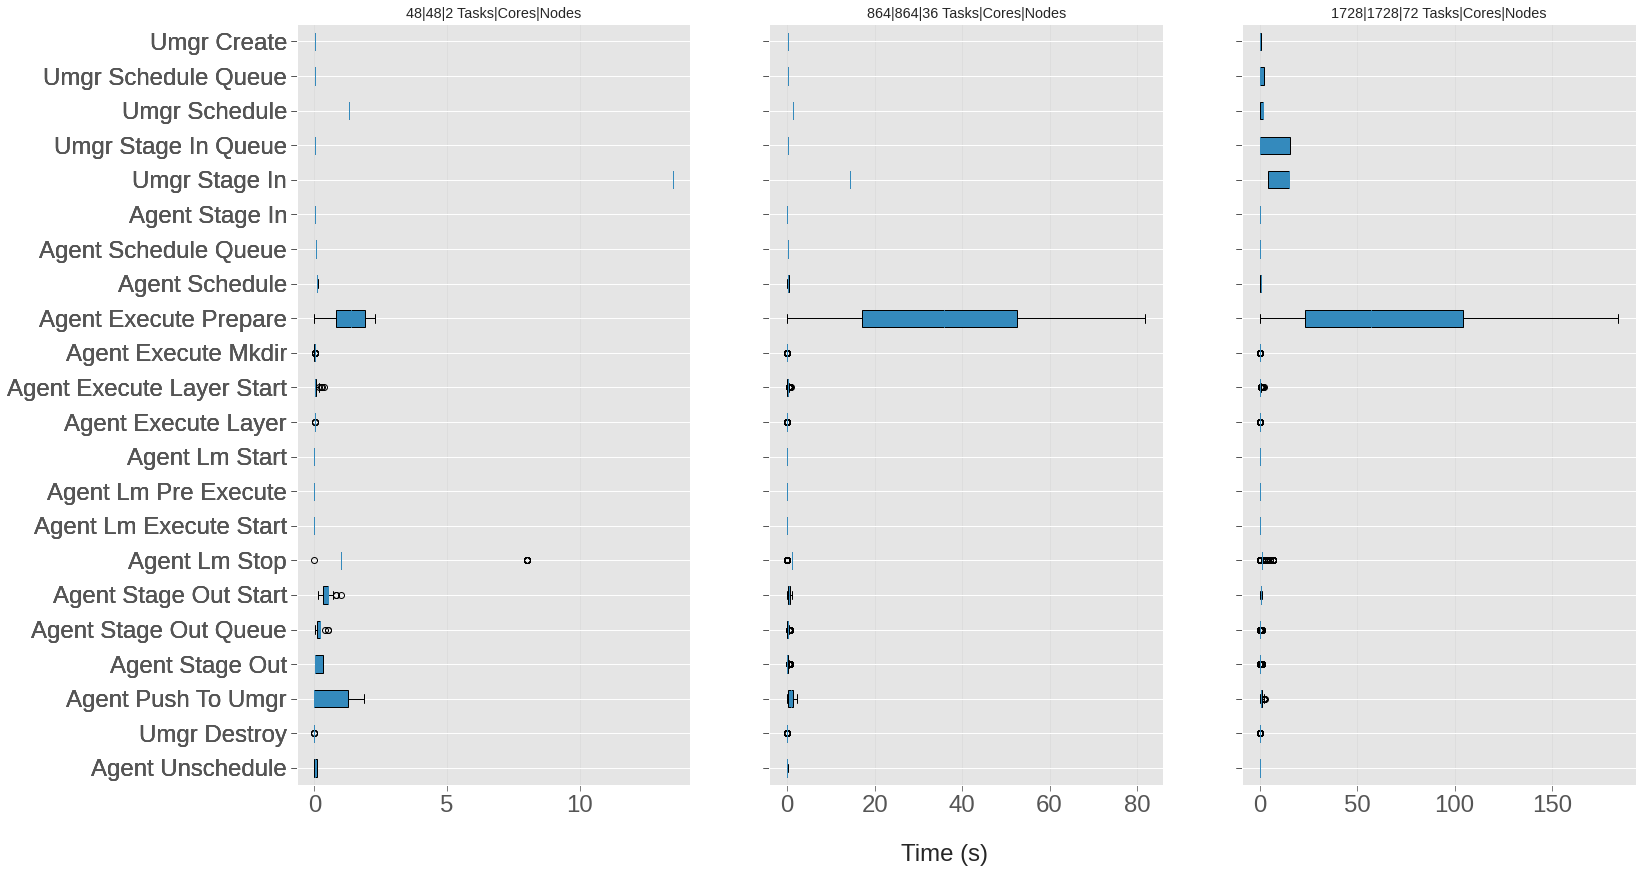

In [10]:
nsessions = len(suds)

fwidth = 8*nsessions
fhight = 14

fig, axarr = plt.subplots(nrows=1, ncols=nsessions, figsize=(fwidth, fhight), sharey=True)

i = 0
j = 'a'
for sid in suds:

    if nsessions > 1:
        ax = axarr[i]
    else:
        ax = axarr

    labels = []
    muted = ['u_agent_lm_execute', 'u_agent_stage_in_queue', 'u_agent_execute_queue'] #Based on Matteo's advice we drop these since it is covering the other metrics(we know that the TTX is ~300 seconds so just drop it)

    if set(muted).issubset(u_durations_df[sid].columns):
        durations = u_durations_df[sid].drop(muted, axis=1)
    else:
        durations = u_durations_df[sid]

    for label in durations.columns:
        labels.append(label.replace("_", " ").title().replace("U ", "").replace("Cu", "CU"))
    labels = list(reversed(labels))

    boxes = []
    for duration in list(reversed(durations.columns)):
        boxes.append(durations[duration].values)
        
    ax.title.set_text('%s|%s|%s Tasks|Cores|Nodes' % (ss[sid]['nunit'],ss[sid]['ncores'], int(ss[sid]['nnodes'])))

    ax.boxplot(boxes, patch_artist=True, labels=labels, vert=False),

    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.5 , 0.05, 'Time (s)', ha='center', fontsize=24)

plt.savefig('../figures/ws_rp_distribution_unit_durations.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('figures/incite2020_distribution_unit_durations.png', dpi=300, bbox_inches='tight')

In [11]:
p_durations = {}

for sid in suds:
    p_durations[sid] = {}

for sid in suds:
    for pid in ss[sid]['p'].list('uid'):
        pilot = ss[sid]['p'].get(etype='pilot', uid=pid)[0]
        durations = {}
        for k,v in rp.utils.PILOT_DURATIONS_DEBUG.items():
            try:
                durations[k] = pilot.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, pid, v))
                durations[k] = 0
        p_durations[sid].update({pid: durations})

In [12]:
p_durations_df = {}
for sid,durations in p_durations.items():
    p_durations_df[sid] = pd.DataFrame.from_dict(durations, orient='index')

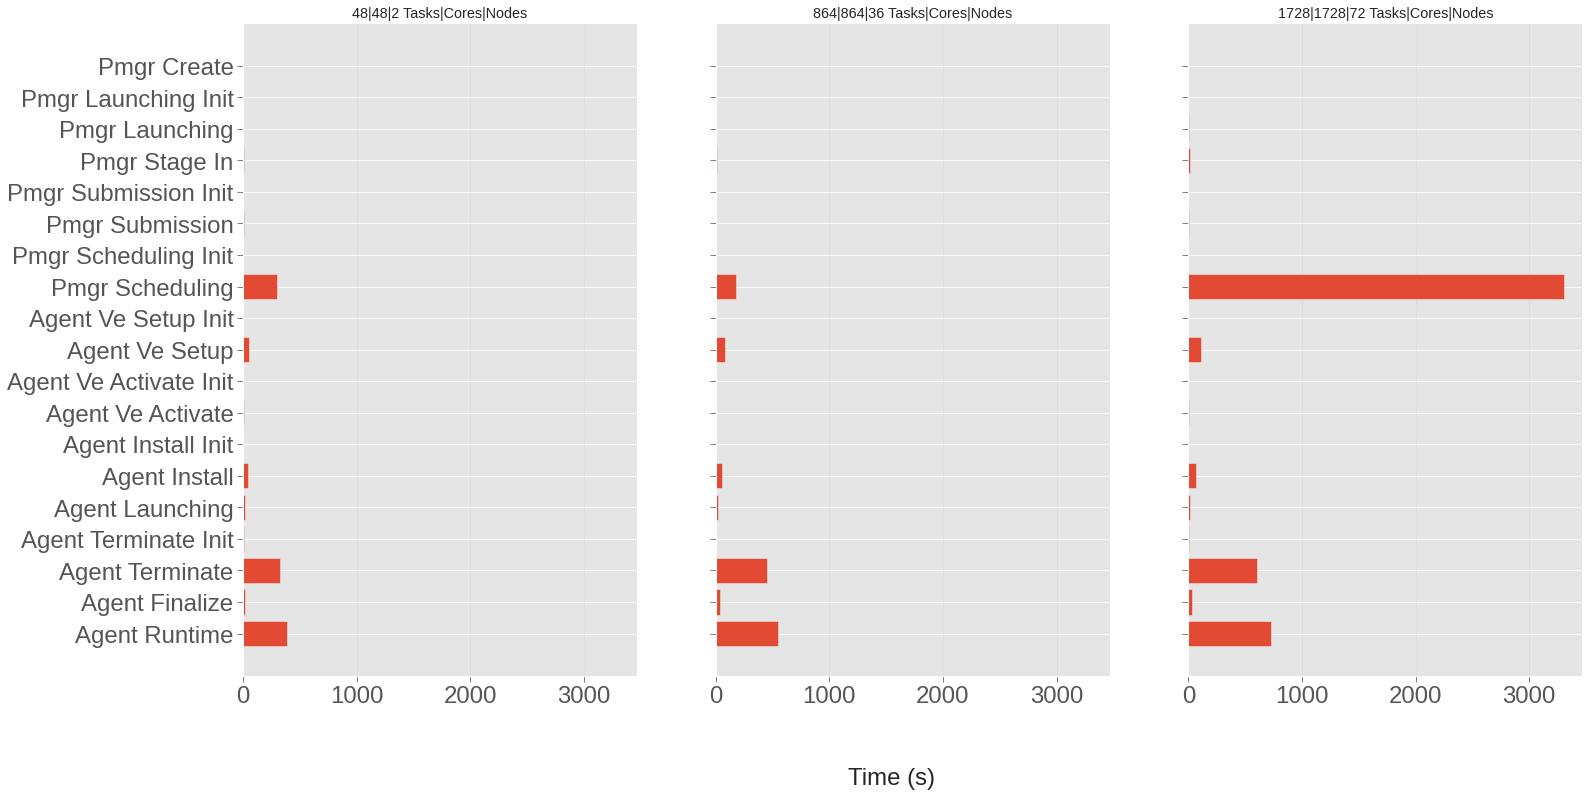

In [13]:
nsessions = len(suds)

fwidth = 8*nsessions
fhight = 12

fig, axarr = plt.subplots(nrows=1, ncols=nsessions, figsize=(fwidth, fhight), sharex=True, sharey=True)

i = 0
j = 'a'
for sid in suds:

    if nsessions > 1:
        ax = axarr[i]
    else:
        ax = axarr

    labels = []
    muted = ['p_pmngr_scheduling', 'p_agent_runtime'] # p_pmngr_scheduling, 'p_agent_runtime'
    muted += [key for key in rp.utils.UNIT_DURATIONS_DEBUG.keys() if 'init' in key.lower()]

    if set(muted).issubset(p_durations_df[sid].columns):
        durations = p_durations_df[sid].drop(muted, axis=1)
    else:
        durations = p_durations_df[sid]

    for label in durations.columns:
        labels.append(label.replace("_", " ").title().replace("P ", ""))
    labels = list(reversed(labels))

    boxes = []
    for duration in list(reversed(durations.columns)):
        boxes.append(durations[duration].values[0])
        
    ax.title.set_text('%s|%s|%s Tasks|Cores|Nodes' % (ss[sid]['nunit'],ss[sid]['ncores'], int(ss[sid]['nnodes'])))
    ax.barh(labels, boxes),

    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.5 , 0, 'Time (s)', ha='center', fontsize=24)

plt.savefig('../figures/ws_rp_distribution_pilot_durations.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('../figures/rp_distribution_pilot_durations.png', dpi=300, bbox_inches='tight')

In [14]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Exec',      ['exec_queue', 'exec_prep']],
        ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Exec Cmd',          ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [15]:
%%capture capt

# Remove cache to avoid reloading errors
! rm -r ~/.radical/analytics

sobjs = ra.Experiment(sids, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

In [16]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

In [17]:
# zero points to zero the axes of the plot.
p_zeros = {}
for session in sobjs.sessions:
    for pilot in session.get(etype='pilot'):
        p_zeros[session.uid] = pilot.timestamps(event={ru.EVENT: 'bootstrap_0_start'})[0]

In [18]:
def update_ticks(x, pos):
    return int(x/168)

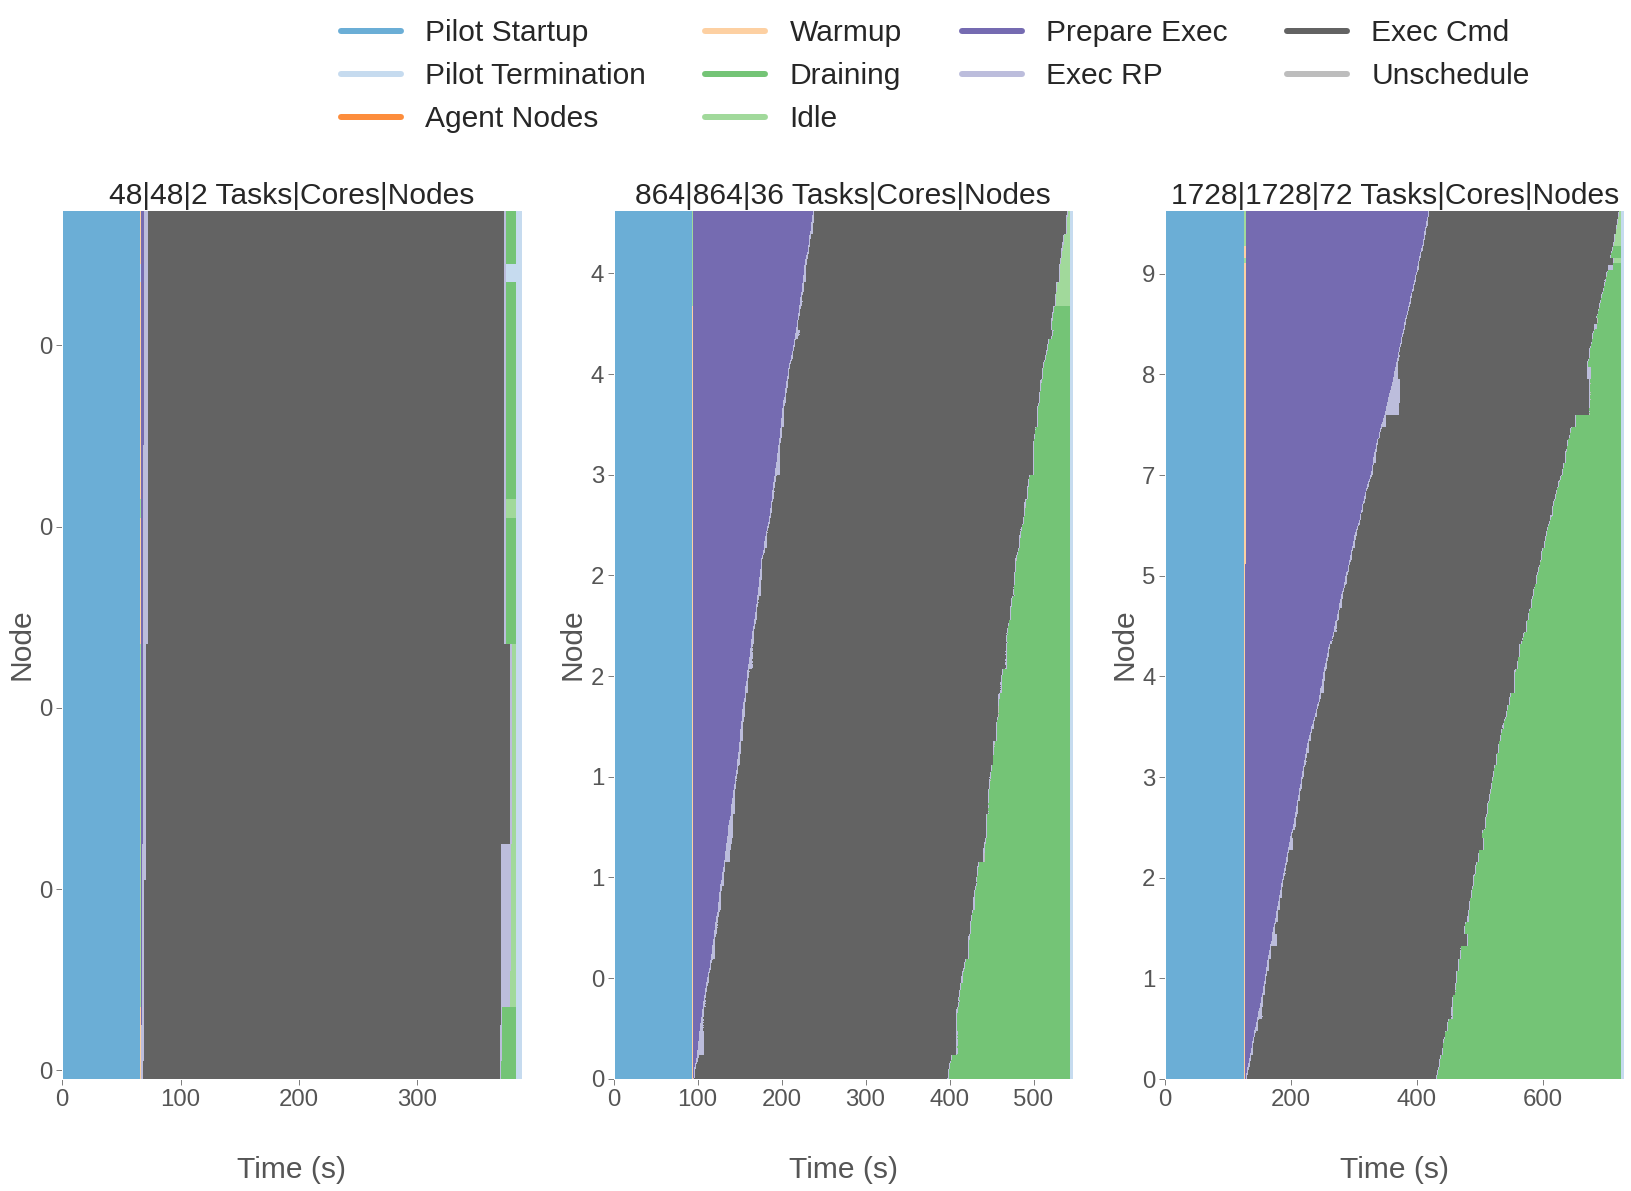

In [19]:
# add share x axis option
skip = []
nsids = len(suds) - len(skip)

fwidth = 28
fhight = 16
fig, axarr = plt.subplots(1, nsids, sharex='col', figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    
    if sid in skip:
        continue

    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=45)
    else:
        ax = axarr

    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.set_title(('%s|%s|%s Tasks|Cores|Nodes' % (ss[sid]['nunit'],ss[sid]['ncores'], int(ss[sid]['nnodes']))), fontdict={'fontsize': 30})

    for metric in metrics_default:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]
 
        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0] - p_zeros[sid]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('Time (s)', fontsize=30)
    ax.set_ylabel('Node', fontsize=30)
    
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)
    
# Add legend
ax.legend(legend, [m[0] for m in metrics_default], loc='upper center',
           bbox_to_anchor=(-0.5, 1.25), fontsize=30, ncol=4)

#plt.savefig('../figures/ws_ru_warming.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('../figures/events_ru.png', dpi=300, bbox_inches='tight')